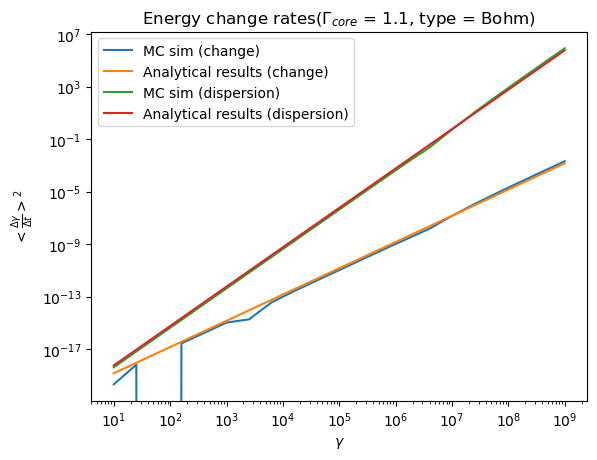

[2.0898041746307845977e-20, 6.489887811892833104e-19, -5.8999387631911876147e-16, 2.7036634484468445517e-17, 1.681761671048523101e-16, 1.0538464158538743564e-15, 1.8626654294698744562e-15, 3.6576540729977401474e-14, 2.6375668184458444562e-13, 1.6679731558498352289e-12, 1.05227612077137876174e-11, 6.6336313583499647765e-11, 4.1620493168233358254e-10, 2.509048446202198281e-09, 1.4773504631035592973e-08, 1.4137693801062536567e-07, 1.1271774626690541865e-06, 7.836009974127771969e-06, 5.1302526148252920406e-05, 0.0003268157614280884968, 0.0020431379538207928284]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import astropy.constants as const

with open('/home/wsy/Acc_MC/MC_sim/paras.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
pi = np.pi
c = (const.c.cgs).value
m_p = (const.m_p.cgs).value
m_e = (const.m_e.cgs).value
e = (const.e.esu).value
    
R_sh = float(config['R_sh'])
GM0 = float(config['GM0'])
eta = float(config['eta'])
beta_min = float(config['beta_min'])
B0 = float(config['B0'])
xi = float(config['xi'])
Lam_max = float(config['Lam_max'])
g_me0 = float(config['g_me0']) 
r0 = float(config['r0'])
n_p = float(config['n_p'])

N_par = int(config['N_par']) # 粒子数
N_time = int(float((config['N_time']))) # 时间步数
N_bins = int(config['N_bins']) # 时间步长

jet_type = str(config['type'])
syn = bool(config['SYN_flag'])
SA = bool(config['SA_flag'])
Sh = bool(config['Shear_flag'])
ESC = bool(config['ESC_flag'])

if jet_type=='kolgv': 
    q = 5/3
elif jet_type=='Bohm':
    q = 1
elif jet_type=='HS':
    q = 2
else:
    raise ValueError("The input should be meaningful")


def beta_dis(r):
    beta_max = np.sqrt(1-1/GM0**2)
    r1 = eta*R_sh
    if (r < r1):
        return beta_max
    elif (r > R_sh):
        return 0.0
    else: 
        return beta_max-((beta_max-beta_min)/(R_sh-r1))*(r-r1)
    
def Rg_calc(g_me):
    return np.sqrt(g_me**2)*m_e*c**2/(e*B0)


def tau_calc(g_me):
    return Rg_calc(g_me)**(2-q)*Lam_max**(q-1)*(c*xi)**(-1)

def T_sh(B0,gme):
    beta0 = beta_dis(0) #中心流速
    beta = beta_dis(r0) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Delta_r = rate*R_sh
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    Gamma_j4 = 1/(1-beta**2)**2
    A1=(2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*A_sc
    t_sh = 2*gme**(q-2)/(A1*(6-q))
    return t_sh

def Dispr_gamma(gme):
    beta0 = beta_dis(0) #中心流速
    beta = beta_dis(r0) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Gamma_j4 = 1/(1-beta**2)**2
    Delta_r = rate*R_sh
    res = (2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*gme**2*tau_calc(gme)
    return res
    
ba = B0 / np.sqrt(B0**2 + 4 * pi * n_p * m_p * c**2)  # 无量纲Alfven波速

nan = np.nan
tar_dir = '/home/wsy/Acc_MC/MC_sim/codes/Code_Trials/cpp_results/'
dgammas = np.loadtxt(tar_dir + 'results.txt')
#print(gammas)
gmes = dgammas[-1,:]
tau = tau_calc(gmes)
tau0 = tau_calc(100)
ave_list1 = []
ave_list2 = []
for i in range(len(dgammas[0,:])):
    mean_rate = np.mean((dgammas[: -1, i])/tau[i], dtype=np.float128)
    #print(gmes[i])
    ave_list1.append(mean_rate)

for j in range(len(gammas[0,:])):
    mean_rate2 = np.mean(dgammas[: -1, j])**2/tau[j], dtype=np.float128)
    ave_list2.append(mean_rate2)
    
t_sh = T_sh(B0,gmes)
rates = gmes/t_sh
disps = Dispr_gamma(gmes)
#print(ave_list)
plt.plot(gmes, ave_list1, label = 'MC sim (change)')
plt.plot(gmes, rates, label = 'Analytical results (change)')
plt.plot(gmes, ave_list2, label = 'MC sim (dispersion)')
plt.plot(gmes, disps, label = 'Analytical results (dispersion)')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Energy change rates($\Gamma_{core}$ = %s, type = %s)'%(GM0,jet_type))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$<\frac{\Delta \gamma}{\Delta t}>^2$')
plt.legend()
plt.show()

print(ave_list1)